In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [69]:
# Load data
pit = pd.read_csv('dataset/pit_stops.csv')
results = pd.read_csv('dataset/results.csv')
status = pd.read_csv('dataset/status.csv')
race = pd.read_csv('dataset/races.csv')

In [77]:
# Merge tables
select_col = ['raceId','year','round','circuitId','name','date']
merge_df = pd.merge(pit, race[select_col], on='raceId', how='left')
select_col = ['raceId','driverId','positionOrder', 'laps', 'time','statusId']
merge_df = pd.merge(merge_df,results[select_col], on=['raceId','driverId'], how = 'left', suffixes=('_pit', '_result'))
merge_df = pd.merge(merge_df, status, on='statusId', how='left')

Meaning of merge_df column: Status

+1 lap means that you have been overtaken by the race leader and that they are behind the race by 1 lap. So if the race has 30 laps , they are timed for 29 laps only hence +1.

If the winner is able to do it twice , it will be shown as +2 so on ...

In [78]:
# Filter records by their Status values (keep only finished and +? laps)
status_select = [1, 11, 12, 13, 14, 15, 16, 17, 18, 19]
merge_df.drop(merge_df[~merge_df['statusId'].isin(status_select)].index, inplace=True)

In [79]:
# Get total stops & laps for each race record
total_laps = merge_df[(merge_df['positionOrder'] == 1) & (merge_df['stop'] == 1)].reset_index(drop=True)[['raceId', 'laps']]
total_laps.columns = [str(total_laps.columns[0]), 'total_laps']
total_stops = merge_df.groupby(by=['raceId', 'driverId'], as_index=False)['stop'].max()
total_stops.columns = list(total_stops.columns[:2]) + ['total_stops']

merge_df = pd.merge(merge_df, total_laps, on='raceId')
merge_df = pd.merge(merge_df, total_stops, on=['raceId', 'driverId'])

In [87]:
# Get the proportion of laps completed for each pit stop
merge_df['lap_prop'] = merge_df.apply(lambda x: x['lap']/x['total_laps'], axis=1)

In [103]:
def group_by_stop_num(df):
    pit_stop_max = df['total_stops'].max()
    df_dict = {}
    for i in range(1, pit_stop_max+1):
        df_dict[i] = df[df['total_stops']==i][['stop','lap_prop']]
    return df_dict

In [104]:
df_dict = group_by_stop_num(merge_df)

In [134]:
len(merge_df[merge_df['total_stops'].isin([1,2,3])]['lap_prop'])/len(merge_df['lap_prop'])

0.8382847533632287

We only select the rows that pit stopped 1, 2, or 3 times, which take up 84% of our data.

In [143]:
round(0.2542151, ndigits=3)

0.254

////////////////////////////////////////////////////////////////////////////////////////
Total Pit Stops:  1
No.  1  pit stop: 
    mean =  0.408  standard deviation =  0.147
    Around 65.7% of values are within 1 standard deviation of the mean
    Around 95.7% of values are within 2 standard deviations of the mean


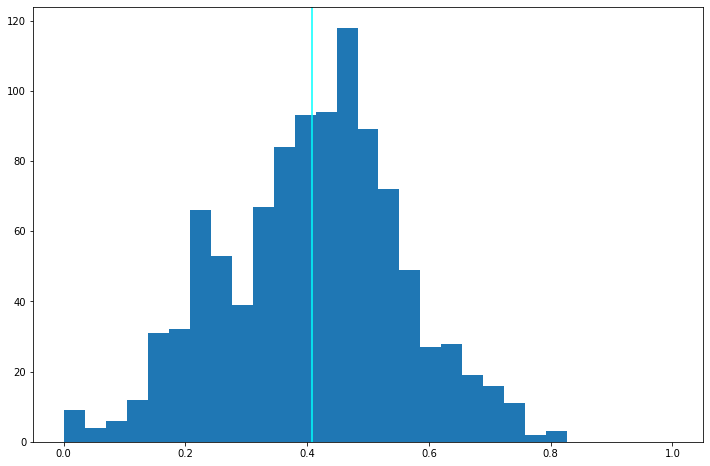

////////////////////////////////////////////////////////////////////////////////////////
Total Pit Stops:  2
No.  1  pit stop: 
    mean =  0.25  standard deviation =  0.113
    Around 71.0% of values are within 1 standard deviation of the mean
    Around 91.9% of values are within 2 standard deviations of the mean
No.  2  pit stop: 
    mean =  0.618  standard deviation =  0.127
    Around 71.6% of values are within 1 standard deviation of the mean
    Around 94.1% of values are within 2 standard deviations of the mean


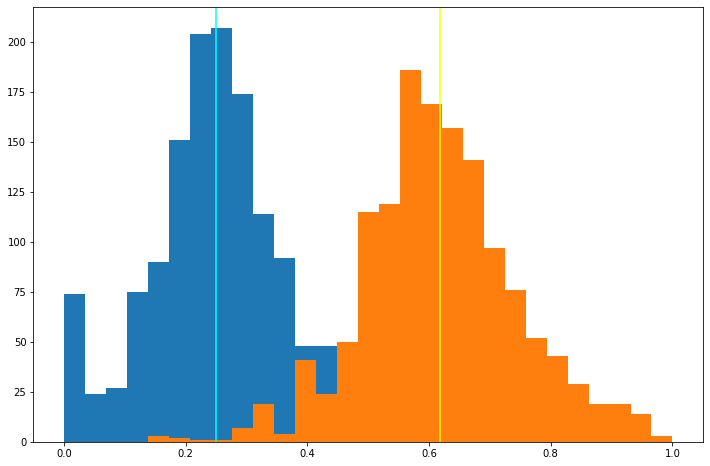

////////////////////////////////////////////////////////////////////////////////////////
Total Pit Stops:  3
No.  1  pit stop: 
    mean =  0.175  standard deviation =  0.095
    Around 68.1% of values are within 1 standard deviation of the mean
    Around 97.0% of values are within 2 standard deviations of the mean
No.  2  pit stop: 
    mean =  0.43  standard deviation =  0.126
    Around 72.7% of values are within 1 standard deviation of the mean
    Around 94.4% of values are within 2 standard deviations of the mean
No.  3  pit stop: 
    mean =  0.706  standard deviation =  0.11
    Around 74.4% of values are within 1 standard deviation of the mean
    Around 93.4% of values are within 2 standard deviations of the mean


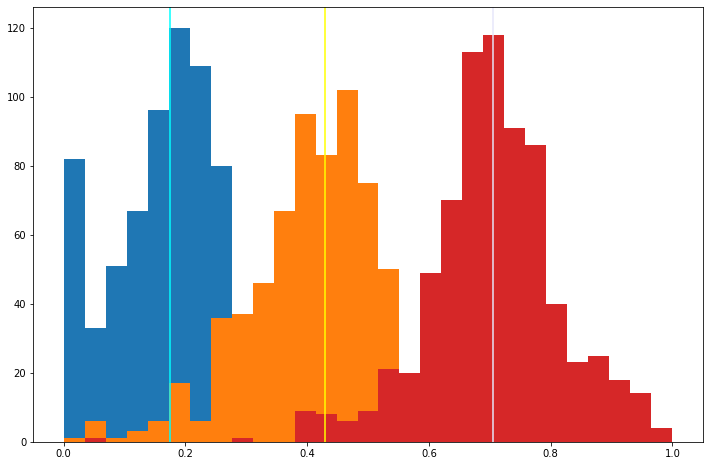

In [161]:
bins = np.linspace(0,1,30)
color_bin = ['tab:blue', 'tab:orange', 'tab:red']
color_bin2 = ['cyan', 'yellow', 'lavender']

max_num_of_stops = 3
for ps_num in range(1, max_num_of_stops+1):
    plt.figure(figsize=(12,8))
    df_tmp = df_dict[ps_num]
    df_list = [df_tmp[df_tmp['stop'] == i]['lap_prop'] for i in range(1, ps_num+1)]
    # plt.hist(df_list, bins, label=[str(i) for i in range(1,ps_num+1)])

    plot_count = 0
    print('////////////////////////////////////////////////////////////////////////////////////////')
    print('Total Pit Stops: ', ps_num)
    for df in df_list:
        plt.hist(df, bins, alpha=1, color=color_bin[plot_count])
        df_mean = round(df.mean(), ndigits=3)
        df_std = round(df.std(), ndigits=3)
        plt.axvline(x=df_mean, color=color_bin2[plot_count])
        plot_count += 1
        print('No. ', plot_count, ' pit stop: ')
        print('    mean = ', df_mean, ' standard deviation = ', df_std)
        perc_1 = len(df[(df <= df_mean + df_std) & (df >= df_mean - df_std)])/len(df)
        perc_2 = len(df[(df <= df_mean + 2*df_std) & (df >= df_mean - 2*df_std)])/len(df)
        perc_1 = round(100*perc_1, ndigits=1)
        perc_2 = round(100*perc_2, ndigits=1)
        print(f'    Around {perc_1}% of values are within 1 standard deviation of the mean')
        print(f'    Around {perc_2}% of values are within 2 standard deviations of the mean')
    plt.show()
